# Header

In [56]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import astropy.units as u
from astropy.constants import h

import flux

# off-axis flux from an infinitestimal top-hat jet

In [1]:
%%time

# returns energy flux in unit [erg cm^-2 s^-1]
# E0, g0:initial E_iso and Lorentz factor
# energy: energy in observer frame; time: time in observer frame since merger
# theta_obs:viewing angle from jet [rad]; D_L:luminosity distance
(flux.tophat(E0=1e51*u.erg, g0=300, energy=1.4*u.GHz*h, time=10*u.day, theta_obs=0.5, D_L=40*u.Mpc)/(1.4*u.GHz)).to(u.uJy)

CPU times: user 768 ms, sys: 227 ms, total: 995 ms
Wall time: 997 ms


<Quantity 0.32027454 uJy>

# off-axis flux from a structured jet (default quad integral)

In [3]:
%%time

# Gaussian jet
Eiso0 = lambda theta: 10**(51) * u.erg * np.exp(-(theta/0.1)**2/2)
Gamma0 = lambda theta: 1 + (300-1) * np.exp(-(theta/0.1)**2/2)

# Eiso0, Gamma0: initial jet profile, should be callable function of single argument theta (angle from jet axis)
# takes ~ 2min, too slow
(flux.structure(Eiso0, Gamma0, energy=1.4*u.GHz*h, time=10*u.day, theta_obs=0.5, D_L=40*u.Mpc)/(1.4*u.GHz)).to(u.uJy)

CPU times: user 1min 48s, sys: 1.44 s, total: 1min 49s
Wall time: 2min 6s


<Quantity 15.02384352 uJy>

# off-axis flux from a structured jet (smart integral)

In [2]:
%%time

# Gaussian jet
Eiso0 = lambda theta: 10**(51) * u.erg * np.exp(-(theta/0.1)**2/2)
Gamma0 = lambda theta: 1 + (300-1) * np.exp(-(theta/0.1)**2/2)

# configure integral range
int_config = flux.int_config(Eiso0, Gamma0, energy=1.4*u.GHz*h, time=10*u.day, theta_obs=0.5, D_L=40*u.Mpc)

CPU times: user 9.56 s, sys: 142 ms, total: 9.7 s
Wall time: 10.1 s


In [3]:
%%time

# only ~2sec for integral with given configuration (int_config)
(flux.structure_smart(Eiso0, Gamma0, energy=1.4*u.GHz*h, time=10*u.day, theta_obs=0.5, D_L=40*u.Mpc, int_config=int_config)/(1.4*u.GHz)).to(u.uJy)

CPU times: user 2.13 s, sys: 25.3 ms, total: 2.15 s
Wall time: 2.16 s


<Quantity 12.94853764 uJy>

# use interpolation to further reduce calculation time

In [89]:
%%time

# flux.int_config takes ~ 10sec everytime to find the effective integral region.
# It's hence economic to create beforehand an interpolatable table of flux.int_config, "int_config_interp",
# e.g. in different "time" and "theta_obs" (flux.int_config is not so sensitive to "energy").

from scipy.interpolate import interp2d

# Gaussian jet
Eiso0 = lambda theta: 10**(51) * u.erg * np.exp(-(theta/0.1)**2/2)
Gamma0 = lambda theta: 1 + (300-1) * np.exp(-(theta/0.1)**2/2)

# interpolatable table of "int_config" in the range t=0.01-1000d and theta_obs=0-pi/2
log10time_l = np.linspace(-2, 3, 6) # better use log-scale in time for interpolation
theta_obs_l = np.linspace(0, 0.5, 6)

# WARNING: it may take ~ 1hr!!
int_config_l = [[flux.int_config(Eiso0, Gamma0, energy=1.4*u.GHz*h, time=10**log10time * u.d, theta_obs=theta_obs, D_L=40*u.Mpc) for log10time in log10time_l] for theta_obs in theta_obs_l]
# np.save('int_config_l', int_config_l)
# int_config_l = np.load('int_config_l.npy')

# interpolation
int_config_interp = lambda time, theta_obs: [interp2d(log10time_l, theta_obs_l, [[col[0] for col in row] for row in int_config_l])(np.log10(time.to_value(u.d)), theta_obs)[0], 
 interp2d(log10time_l, theta_obs_l, [[col[1] for col in row] for row in int_config_l])(np.log10(time.to_value(u.d)), theta_obs)[0], 
 interp2d(log10time_l, theta_obs_l, [[col[2] for col in row] for row in int_config_l])(np.log10(time.to_value(u.d)), theta_obs)[0],
]

CPU times: user 1h 2min 27s, sys: 48.4 s, total: 1h 3min 16s
Wall time: 1h 5min 58s


CPU times: user 50.1 ms, sys: 7.97 ms, total: 58 ms
Wall time: 60.2 ms


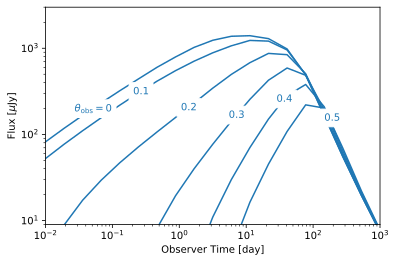

In [115]:
%%time

# 1.4 GHz radio light curve

from labellines import *

t_l = np.logspace(-2, 3, 19)

lc_l = [[(flux.structure_smart(Eiso0, Gamma0, energy=1.4*u.GHz*h, time=t*u.d, theta_obs=theta_obs, D_L=40*u.Mpc, int_config=int_config_interp(t*u.d, theta_obs))/(1.4*u.GHz)).to_value(u.uJy) for t in t_l] for theta_obs in [0, 0.1, 0.2, 0.3, 0.4, 0.5]]

for flux_l, label in zip(lc_l, [r'$\theta_{\rm obs}=0$', '0.1', '0.2', '0.3', '0.4', '0.5']):
    plt.loglog(t_l, flux_l, c='C0', label=label)

plt.xlim([1e-2, 1e3])
plt.ylim([9e0, 3e3])
plt.xlabel('Observer Time [day]')
plt.ylabel(r'Flux [$\mu$Jy]')
labelLines(plt.gca().get_lines(), align=False)